# Les requêtes imbriquées avec Neo4J
Ce rapport a pour objectif de montrer l'utilisation des requêtes imbriquées dans le système de gestion de base de donnée Neo4j.
Pour pouvoir executer le code présent dans les cellules suivantes il faut avoir neo4j lancé, utiliser un docker est possible avec : 

``` docker run --publish=7474:7474 --publish=7687:7687 -v $PWD/import:/var/lib/neo4j/import neo4j:4.1.3```


Il faut que le fichier small-pubg.csv soit present dans un dossier import a la racine du projet

## Un peu de contexte

Neo4j est un système de gestion de base de donnée orientée graphe. Ce type de système a la particularité d'utiliser des graphes pour représenter les données et ainsi permettre les formules connus de la théorie des graphes. De plus Neo4j est connu pour sa performance dans la rapidité des requêtes qui sont dans certains cas plus rapide que des simples requêtes SQL.Le langage de requête utilisé par Neo4j est le langage cypher reconnu pour permettre des requêtes clair et simple. 

Un autre avantage de ce type de base de donnée est la simplicité et la clareté des graphes produits qui peuvent être utilisé simplement par différents domaine métiers par exemple des analyste sans compêtences informatique nécessaire il suffit de regarder les relations entre les noeuds pour pouvoir comprendre facilement le modèle de donnée les relations présente et leurs implication.

Neo4j fournit un serveur avec une console permettant d'éxécuter les requêtes mais également un interface web plus simple à utiliser. Neo4j permet grâce à cette interface facilement maniable de mettre en évidence ou de déplacer certains noeuds, ainsi en clickant que un noeud l'on peut voir ses relations avec les autres et les déplacer pour clarifier la lecture. 

Le principal défault de Neo4j est l'hébergement, Chaque serveur ne peut héberger que une base
de données.


Les requêtes imbriquées (ou sous requête) permettent de faire une requête sur une requête et donc cibler plus simplement un resultat.
En SQL par exemple une requête de ce type ressemble à ça : ```SELECT a FROM b WHERE a IN (SELECT c FROM b) ```
A l'aide de la bibliothèque python py2neo nous allons vous montrer comment on peut utiliser ces requêtes. Nous utilisons la verion 4.1.3 de neo4j, en effet les sous requêtes sont assez récente dans le langage et il faut au moins utiliser la version 4.0.0.

## Installation

Nous utiliserons donc les librairies suivantes permettant de faire des requêtes à notre base neo4j depuis jupyter.


```python pip3 install py2neo ```


```python pip3 install neo4jupyter ```


Il faut également installer Java car Neo4j a été codé en Java.

--------

# Import des données pubg dans un graphe et exemple d'utilisation

### Connexion à la base neo4j

In [9]:
from py2neo import *
from neo4jupyter import *

graph = Graph('http://localhost', auth=('neo4j', 'neo4j*'))
print("connect")

connect


### Import des données pubg

Il faut que $neo4jhome/import/small-pubg sois défini

Ici Merge permet de créer des entités à partir du csv chargé nous créons donc trois entitées pour les joueurs les équipes et les matchs (un joueur appartient à une équipe et joue dans un match)

In [10]:
loadQuery = '''
USING PERIODIC COMMIT
LOAD CSV WITH HEADERS FROM 'file:///small-pubg.csv' AS pubg
WITH pubg
WHERE pubg.match_id IS NOT NULL AND pubg.player_name IS NOT NULL
MERGE (player:Player{
        assists:pubg.player_assists,
        name:pubg.player_name,
        kills:pubg.player_kills,
        surviveTime:pubg.player_survive_time,
        dmg:pubg.player_dmg,
        dbno:pubg.player_dbno,
        distRide:pubg.player_dist_ride,
        distWalk:pubg.player_dist_walk
        
        })
MERGE (match:Match{
         matchId:pubg.match_id,
         matchMode:pubg.match_mode,
         size:pubg.game_size,
         date: pubg.date
         })
MERGE (team:Team{
        teamId:pubg.team_id,
        teamPlacement:pubg.team_placement
        })
MERGE (player) -[:belongs_to]-> (team)
MERGE (player) -[:plays_in]-> (match)

'''
graph.run(loadQuery)
print("ok")

ok


### Visualisation du graphe 

Cette cellule permet d'avoir un aperçu visuel du graphe produit, pour créer cette aperçu nous utilisons la librairie python neo4jupyter https://github.com/merqurio/neo4jupyter (le résultat de la sortie s'affichant sous forme d'objet sur git, une capture est jointe).

In [11]:
neo4jupyter.init_notebook_mode()
options = {"Player": "name", "Match": "matchId", "Team": "teamId"}
draw(graph, options)

<IPython.core.display.Javascript object>

Capture d'écran d'un zoom sur le graphe ainsi produit

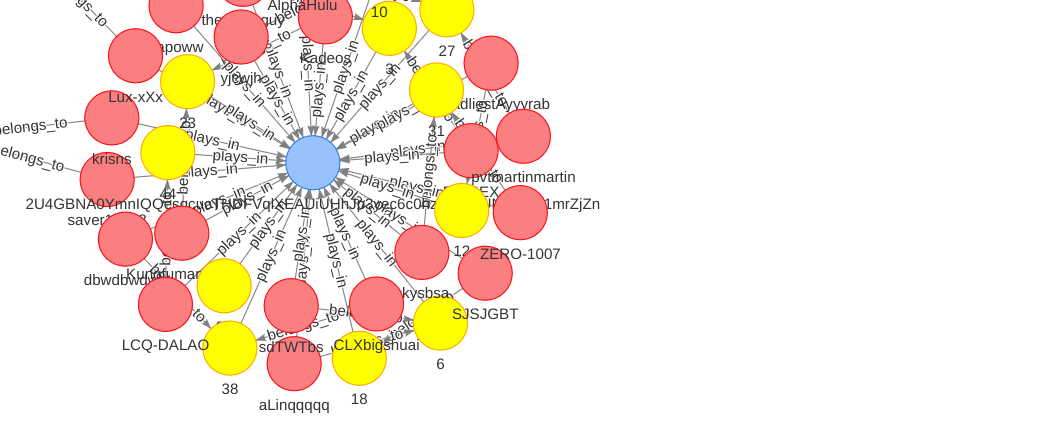

### Exemple de requête similaire à celle de l'Exercice 3 du Tp Spark

Voici un exemple d'utilisation de requête Neo4j avec la question : Obtenez les 10 meilleurs joueurs selon les éliminations (toujours sur le jeu de données avec 100 lignes)

In [43]:
queryTp = '''
MATCH (p:Player) WITH p, count(*) AS c
WHERE c >= 4
RETURN p.name, avg(toInteger(p.kills)) AS avg_kills,  c AS games
ORDER BY avg_kills DESC
LIMIT 10
'''
results = graph.run(queryTp)
print(results.to_table())

 p.name         | avg_kills | games 
----------------|-----------|-------
 ShuLanHou      |       6.0 |     1 
 FetusMunch4000 |       5.0 |     1 
 Maerkk         |       4.0 |     1 
 Cruz914        |       4.0 |     1 
 LPL-buibuibui  |       3.0 |     1 
 SlashTheSoviet |       3.0 |     1 
 Lepore24       |       2.0 |     1 
 hqh0808        |       2.0 |     1 
 GeminiZZZ      |       2.0 |     1 
 Hathawayxu     |       2.0 |     1 



----

# Présentation des requêtes imbriquées

Il existe deux manières de faire les requêtes imbriquées en neo4j :
- Les requêtes existentiel utilisant la clause cypher EXISTS{} dans la clause WHERE
- Les requêtes utilisant la clause CALL et permettant de retourner un résultat



### Requête existentiel
Le principal objectif de ces requêtes est de filtrer les données du graphe pour afficher les données voulu.

Un filtre peut se faire de la manière suivante :



In [29]:
queryFilter = '''
MATCH (p:Player)-[:belongs_to]->(t:Team)
WHERE exists((p)-[:plays_in]->(:Match {matchId: '2U4GBNA0YmnIQQesqcucTHDFVqlXEAUiUHhJp3yec6c0hzQHABUNJuJZ21mrZjZn'}))
RETURN p.name
'''
results = graph.run(queryFilter)
print(results.to_table())

 p.name           
------------------
 krisns           
 saver12138       
 BIGSEX           
 the49ersguy      
 sdTWTbs          
 aLinqqqqq        
 Lux-xXx          
 sapoww           
 yjcwjh           
 5tygfv           
 DeadlyAyrab      
 DeadliestAyyyrab 
 SJSJGBT          
 cole_milk        
 Kadeos           
 Kungfumanduhh    
 AlphaHulu        
 pvtmartinmartin  
 virginiaaaaa     
 DimonGao999      
 skysbsa          
 ZERO-1007        
 CLXbigshuai      
 dbwdbwdwb        
 LCQ-DALAO        



Ici on utilise un filtre qui renvoie le nom de tout les joueurs ayant participé au match ayant pour identifiant 2U4GBNA0YmnIQQesqcucTHDFVqlXEAUiUHhJp3yec6c0hzQHABUNJuJZ21mrZjZn pour cela on filtre les equipes auxquelles les joueurs appartiennent

La documentation officielle de Neo4j précise qu'il vaut mieux utiliser une sous requêtes avec la clause EXISTS qui en plus d'être plus performante est plus compréhensible et plus flexible.

Voici comment on peut utiliser une sous requête avec la clause EXISTS pour obtenir le même filtre : 

In [28]:
queryFilterWithSubQuery = '''
MATCH (p:Player)-[:belongs_to]->(t:Team)
WHERE EXISTS {
  MATCH (p)-[:plays_in]->(:Match {matchId: '2U4GBNA0YmnIQQesqcucTHDFVqlXEAUiUHhJp3yec6c0hzQHABUNJuJZ21mrZjZn'})
}
RETURN p.name
'''
results = graph.run(queryFilterWithSubQuery)
print(results.to_table())

 p.name           
------------------
 krisns           
 saver12138       
 BIGSEX           
 the49ersguy      
 sdTWTbs          
 aLinqqqqq        
 Lux-xXx          
 sapoww           
 yjcwjh           
 5tygfv           
 DeadlyAyrab      
 DeadliestAyyyrab 
 SJSJGBT          
 cole_milk        
 Kadeos           
 Kungfumanduhh    
 AlphaHulu        
 pvtmartinmartin  
 virginiaaaaa     
 DimonGao999      
 skysbsa          
 ZERO-1007        
 CLXbigshuai      
 dbwdbwdwb        
 LCQ-DALAO        



On voit bien la seconde requête MATCH imbriqué dans la première à travers la clause EXISTS.
On peut donc maintenant tout a fait ajouter une clause WHERE dans le second MATCH afin d'affiner notre filtrage.
La flexibilité ainsi apporté peut rendre possible des requêtes impossible sans sous requêtes 

exemple :

In [27]:
queryFilterInf = '''
MATCH (p:Player)-[:belongs_to]->(t:Team)
WHERE EXISTS {
  MATCH (p)-[:plays_in]->(m:Match)
  WHERE m.matchId ENDS WITH'ZjZn'
  AND t.teamId < '30'

}
AND p.kills >= '1'
RETURN p.name
ORDER BY p.kills DESC;

'''
results = graph.run(queryFilterInf)
print(results.to_table())

 p.name          
-----------------
 saver12138      
 BIGSEX          
 DeadlyAyrab     
 pvtmartinmartin 



La requête imbriqué ci dessus va chercher les joueurs ayant  participé au match dont l'identifiant fini par 'ZjZn' (soit le même que précedemment), en filtrant les identifiants superieur à 30 et les joueurs ayant un nombre d'élimination inférieur ou égale à 1 en renvoyant le résultat dans l'ordre decroissant. Filtrer à la fois sur l'équipe et sur le match est possible grâce à la sous requête sinon si on avait écrit cette requête : 
```
MATCH (p:Player)-[:plays_in]->(m:Match)
WHERE m.matchId ENDS WITH'ZjZn'
AND t.teamId < '30'
```
la clause WHERE n'a pas accès à Team mais juste à Match et ne permet pas le filtrage

### Requête utilisant la clause CALL

Quand on fait des clause UNION en Neo4j qui effectuent un travail similaire à celui des requêtes imbriquées, le résultat retourné est celui de chaque union et donc le problème se pose si l'on veut par exemple ordonner le résultat, c'est que l'on ne peut que ordonner le résultat de chaque sous requête.
On peut alors utiliser la clause CALL qui permet de retourner un résultat d'une UNION, puis ensuite ordonner celui ci :

In [51]:
queryWithCall = '''
CALL {
    MATCH (p:Player)-[:depends_on]->(t:Team)
    RETURN p
    UNION
    MATCH (p:Player) - [:plays_in]->(m:Match)
    WHERE m.matchId ENDS WITH'ZjZn'
    RETURN p
}
RETURN p.name , p.kills
ORDER BY p.kills DESC;
'''

results = graph.run(queryWithCall)
print(results.to_table())

 p.name           | p.kills 
------------------|---------
 aLinqqqqq        | 2       
 saver12138       | 2       
 sdTWTbs          | 1       
 DeadlyAyrab      | 1       
 pvtmartinmartin  | 1       
 BIGSEX           | 1       
 virginiaaaaa     | 0       
 DimonGao999      | 0       
 DeadliestAyyyrab | 0       
 SJSJGBT          | 0       
 dbwdbwdwb        | 0       
 yjcwjh           | 0       
 ZERO-1007        | 0       
 sapoww           | 0       
 skysbsa          | 0       
 Lux-xXx          | 0       
 the49ersguy      | 0       
 Kungfumanduhh    | 0       
 AlphaHulu        | 0       
 CLXbigshuai      | 0       
 5tygfv           | 0       
 cole_milk        | 0       
 Kadeos           | 0       
 krisns           | 0       
 LCQ-DALAO        | 0       



Ici on fait la même requête que dans la partie précédente en ordonnant nos résultats par nombre d'élimination.

Avec les clauses CALL et UNION, l'on peut effectuer des unions sur toutes les requêtes voulu à condition de retourner les mêmes colomne dans chaque UNION.


# Conclusion

Les requête imbriquées ajoutés récemment à Neo4j, rendent encore plus complet ce système de base de donnée, qui de part son orientation graphe permet une approche différente et parfois plus rapide que les système traditionnelles. Celles-ci apportent également la possibilité de faire des requêtes plus classiques comme celle avec la clause EXISTS ressemblant à des sous requêtes SQL ou CALL permettant de faire des UNION, ces techniques permettent de simplifier nos requêtes et que celles ci soit plus compréhensible ce qui fluidifie ainsi le travail. 